### Fine tuning a BerT model for toxicity

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model, PeftType, TaskType
from transformers import (
    TrainingArguments,
    Trainer,
    TrainerCallback
)

/home/shaunak/.virtualenvs/llm_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

In [25]:
MODEL_NAME = "bert-base-uncased" 
train_data_path = "../data/processed_data/train.json"
test_data_path = "../data/processed_data/test.json"

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:


# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)  # Adjust num_labels based on the task
model.to(device)
print("Is model training? ", model.training)
# Set model to evaluation mode
model.eval()

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

# Example usage
text = "BERT is a powerful language model!"
prediction = predict(text)
print(f"Predicted class: {prediction}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Is model training?  False
Predicted class: 0


In [32]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
lora_model = get_peft_model(model, peft_config)

### Dataset loader

In [7]:
def process_data(tokenizer, data_path = test_data_path):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = '[PAD]'
    dataset = load_dataset("json", data_files=data_path, split="train[:1500]")

    def format_example(example):
        instruction = example['Question']
        inputs = tokenizer(
            f"{instruction}\n<|endoftext|>",
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0), 
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": example["Label"]
        }

    return dataset.map(format_example, remove_columns=dataset.column_names)

In [8]:
data_path = test_data_path
dataset = process_data(tokenizer)

In [34]:
def data_collator(data):
    batch = {
        "input_ids": torch.stack([torch.tensor(d["input_ids"]) for d in data]).to(device),
        "attention_mask": torch.stack([torch.tensor(d["attention_mask"]) for d in data]).to(device),
        # use input_ids as labels.
        "labels": torch.stack([torch.tensor(d["labels"]) for d in data]).to(device)
    }
    return batch

In [35]:
dataloader = DataLoader(dataset, batch_size=8, collate_fn=data_collator)

In [36]:
model.eval()
loss = torch.nn.CrossEntropyLoss()
N = 0
mean_eval_loss = 0
total_accuracy = 0
total_precision = 0
total_f1_score = 0
total_cm = 0

for data in dataloader:
    input_ids = data["input_ids"]
    attention_mask = data["attention_mask"]
    label = data["labels"]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        n = outputs.logits.shape[0]
        custom_loss = - 1 / n * (torch.sum(torch.log(F.softmax(outputs.logits, dim = 1)) * label))
        # Softmax is applied to the first argument
        pytorch_loss = loss(outputs.logits, label)
        mean_eval_loss += n * pytorch_loss
        pred_classes = torch.argmax(outputs.logits, dim = 1)
        label_classes = torch.argmax(label, dim = 1)
        pred_np = pred_classes.detach().cpu().numpy()
        label_np = label_classes.detach().cpu().numpy()
        cm = confusion_matrix(label_np, pred_np, labels = [0, 1, 2])
        total_cm += cm

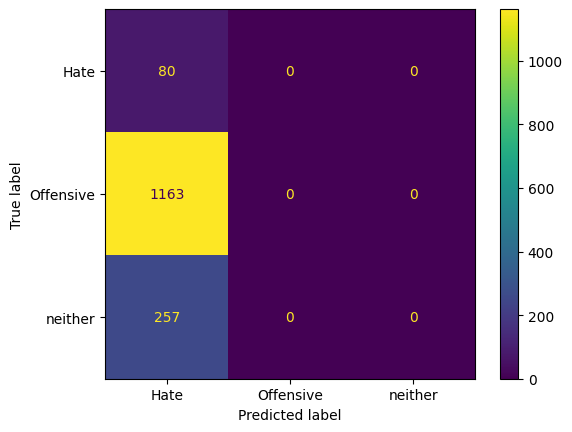

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=total_cm.astype(int), display_labels = ["Hate", "Offensive", "neither"])
disp.plot()
import matplotlib.pyplot as plt
plt.savefig('test.png')

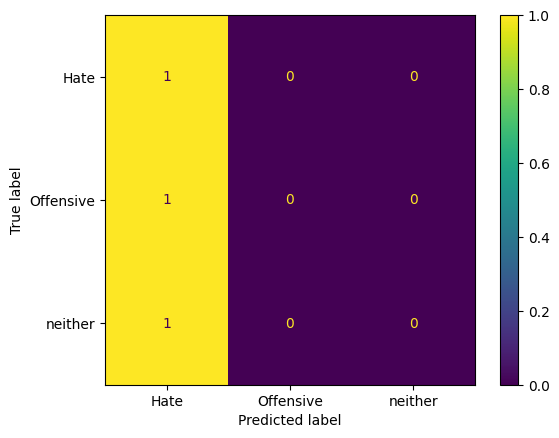

In [38]:
def evaluate_model(model, filename = "test.png"):
    dataset = process_data(tokenizer, test_data_path)
    dataloader = DataLoader(dataset, batch_size=8, collate_fn=data_collator)
    loss = torch.nn.CrossEntropyLoss()
    total_cm = 0
    mean_eval_loss = 0

    for data in dataloader:
        input_ids = data["input_ids"]
        attention_mask = data["attention_mask"]
        label = data["labels"]
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            n = outputs.logits.shape[0]
            # Softmax is applied to the first argument
            pytorch_loss = loss(outputs.logits, label)
            mean_eval_loss += n * pytorch_loss
            pred_classes = torch.argmax(outputs.logits, dim = 1)
            label_classes = torch.argmax(label, dim = 1)
            pred_np = pred_classes.detach().cpu().numpy()
            label_np = label_classes.detach().cpu().numpy()
            cm = confusion_matrix(label_np, pred_np, labels = [0, 1, 2])
            total_cm += cm

    total_cm = total_cm.astype(float)
    total_cm /= total_cm.sum(axis = 1, keepdims = True)
    disp = ConfusionMatrixDisplay(confusion_matrix=total_cm, display_labels = ["Hate", "Offensive", "neither"])
    disp.plot()
    plt.savefig(filename)
    
    

evaluate_model(model, "base_model_stats.png")


## Fine tuning the model

In [14]:
data_path = r"../data/processed_data/train.json"
output_path = r"../output"

# force to use GPU.
assert torch.cuda.is_available(), "Use GPU!"
device = torch.device("cuda")

In [15]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["classifier"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    modules_to_save=None
)

In [16]:
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.losses.append(logs["loss"])

In [17]:
def data_collator(data):
    batch = {
        "input_ids": torch.stack([torch.tensor(d["input_ids"]) for d in data]).to(device),
        "attention_mask": torch.stack([torch.tensor(d["attention_mask"]) for d in data]).to(device),
        # use input_ids as labels.
        "labels": torch.stack([torch.tensor(d["labels"]) for d in data]).to(device)
    }
    return batch

In [18]:
import torch.nn.functional as F
class CustomLossTrainer(Trainer):
    def compute_loss(self, model, inputs, num_items_in_batch, return_outputs = False):
        """
        Custom loss computation method
        
        Args:
            model: The model
            inputs: Input dictionary
            return_outputs: Whether to return model outputs along with loss
        
        Returns:
            Loss, or (loss, outputs) if return_outputs is True
        """
        # Forward pass to get logits
        outputs = model(
            input_ids=inputs['input_ids'], 
            attention_mask=inputs['attention_mask']
        )
        
        # Extract logits and labels
        logits = outputs.logits
        labels = inputs['labels']

        loss = torch.nn.CrossEntropyLoss(reduction='sum')
        # Compute cross-entropy loss
        loss_value = loss(
            logits,
            labels
        )
        return (loss_value, outputs) if return_outputs else loss_value

In [19]:
test_dataset = process_data(tokenizer, data_path=test_data_path)

In [ ]:
# Training arguments.
training_args = TrainingArguments(
    output_dir=output_path,
    per_device_train_batch_size=4,  # storage limited.
    gradient_accumulation_steps=8,  # accumulate gradient, batch_size=8
    num_train_epochs=400,
    learning_rate=3e-4,
    fp16=True,
    logging_steps=1,
    save_strategy="no",
    report_to="none",
    optim="adamw_torch",
    no_cuda=False,
    dataloader_pin_memory=False,  # use pinned memory to accelerate training.
    remove_unused_columns=False  # prevent error.
)

In [45]:
print("Trainable parameter names:")
for name, param in lora_model.named_parameters():
    param.requires_grad = "classifier" in name or "lora" in name

for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"- {name}")

Trainable parameter names:
- base_model.model.bert.encoder.layer.0.attention.self.query.lora_A.default.weight
- base_model.model.bert.encoder.layer.0.attention.self.query.lora_B.default.weight
- base_model.model.bert.encoder.layer.0.attention.self.key.lora_A.default.weight
- base_model.model.bert.encoder.layer.0.attention.self.key.lora_B.default.weight
- base_model.model.bert.encoder.layer.1.attention.self.query.lora_A.default.weight
- base_model.model.bert.encoder.layer.1.attention.self.query.lora_B.default.weight
- base_model.model.bert.encoder.layer.1.attention.self.key.lora_A.default.weight
- base_model.model.bert.encoder.layer.1.attention.self.key.lora_B.default.weight
- base_model.model.bert.encoder.layer.2.attention.self.query.lora_A.default.weight
- base_model.model.bert.encoder.layer.2.attention.self.query.lora_B.default.weight
- base_model.model.bert.encoder.layer.2.attention.self.key.lora_A.default.weight
- base_model.model.bert.encoder.layer.2.attention.self.key.lora_B.defa

In [46]:
loss_callback = LossCallback()
train_dataset = process_data(tokenizer, data_path=train_data_path)
trainer = CustomLossTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
    callbacks=[loss_callback],
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [47]:
trainer.train()

Step,Training Loss
1,3.658700
2,2.734100
3,2.719000
4,2.682000
5,2.860600
6,2.920100
7,2.061400
8,2.648600
9,3.820700
10,3.378200


TrainOutput(global_step=46, training_loss=2.905565127082493, metrics={'train_runtime': 41.3187, 'train_samples_per_second': 36.303, 'train_steps_per_second': 1.113, 'total_flos': 389980557803520.0, 'train_loss': 2.905565127082493, 'epoch': 0.9813333333333333})

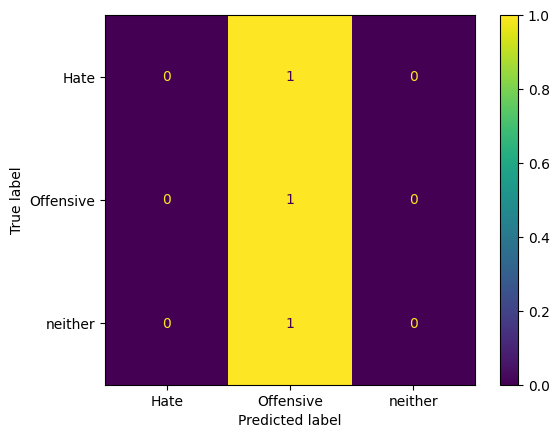

In [48]:
evaluate_model(model, "fine_tuned_stats.png")